In [1]:
import pandas as pd
import re
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Import and Prepare

In [2]:
emotions = ['Agitation', 'Love', 'Joy', 'Sadness', 'Anger', 'Fear', 'None']

In [3]:
data_gen_path = "../resources/data_gen_sampling.tsv"
data_strat_path = "../resources/data_stratified_sampling.tsv"
exp1_data_path = "../resources/exp_1_gen_sample_short_prompt.csv"
exp3_data_path = "../resources/experiment_3_short_prompt_raw_results.csv"
lyrik_shaver_stanza_path = "../resources/lyrik_shaver_stanza.csv"
# eval_results_path = "../resources/eval_results.tsv"

In [4]:
model_factsheets = [
    [
        '../resources/logging_2_exp_chatgpt_1-350.txt',
        'gpt4o',
        'general',
        'long'
    ],
    [
        '../resources/logging_2_exp_gemini_1-350.txt',
        'gemini',
        'general',
        'long'
    ],
    [
        '../resources/logging_2_exp_claude_1-350.txt',
        'claude',
        'general',
        'long'
    ],
    [
        '../resources/logging_4_exp_chatgpt_1-350.txt',
        'gpt4o',
        'stratified',
        'long'
    ],
    [
        '../resources/logging_4_exp_gemini_1-350.txt',
        'gemini',
        'stratified',
        'long'
    ],
]

In [5]:
possible_models = ['gpt4o', 'gemini', 'claude']
possible_prompts = ['long', 'short']
possible_samples = ['general', 'stratified']

### Load df_gen and df_strat

In [6]:
df_gen = pd.read_csv(data_gen_path, sep="\t", index_col=[0])
df_gen['None'] = [int(x) for x in (df_gen[['Agitation', 'Anger', 'Fear', 'Joy', 'Love', 'Sadness']].sum(axis=1) == 0)]

In [7]:
df_strat = pd.read_csv(data_strat_path, sep="\t", index_col=[0])
df_strat['None'] = [int(x) for x in (df_strat[['Agitation', 'Anger', 'Fear', 'Joy', 'Love', 'Sadness']].sum(axis=1) == 0)]

### Import responses from logs and add them to df_gen and df_strat

In [8]:
def get_model_responses (log_output):
    return log_output.split("\n\n")

In [9]:
def get_annotation_from_model_response (response):
    if 'ANNOTATION' in response:
        annotation = re.findall(r'ANNOTATION:.*', response)[0]
        return annotation
    elif any(emotion in response for emotion in emotions):
        return response
    else:
        return 'no_annotation_found'

In [10]:
def get_reasoning_from_model_response (response):
    if 'REASONING' in response:
        reasoning = re.findall(r'REASONING:.*', response)[0]
        return reasoning
    else:
        return 'no_reasoning_found'

In [11]:
for model_factsheet in model_factsheets:
    model_log_path = model_factsheet[0]
    model_name = model_factsheet[1]
    sample_name = model_factsheet[2]
    prompt_name = model_factsheet[3]

    log_output = open(model_log_path,'r').read()
    model_responses = get_model_responses(log_output)

    for response in model_responses:    
        index = re.findall("\\d+", response)
    
        if len(index) != 1:
            print(f"Error : no index found")
            print(f"model_log_path : {model_log_path}")
            print(f"model_name     : {model_name}")
            print(f"sample_name    : {sample_name}")
            print(f"prompt_name    : {prompt_name}")
            print(f"response       : {response}")
            print("\n")
            continue
            
        index = int(index[0])
        
        if sample_name == 'general':
            df_gen.at[index, f'{model_name}_{prompt_name}_response'] = response
            df_gen.at[index, f'{model_name}_{prompt_name}_annotation'] = get_annotation_from_model_response(response)
            df_gen.at[index, f'{model_name}_{prompt_name}_reasoning'] = get_reasoning_from_model_response(response)
            
        if sample_name == 'stratified':
            df_strat.at[index, f'{model_name}_{prompt_name}_response'] = response
            df_strat.at[index, f'{model_name}_{prompt_name}_annotation'] = get_annotation_from_model_response(response)
            df_strat.at[index, f'{model_name}_{prompt_name}_reasoning'] = get_reasoning_from_model_response(response)

Error : no index found
model_log_path : ../resources/logging_2_exp_claude_1-350.txt
model_name     : claude
sample_name    : general
prompt_name    : long
response       : 


Error : no index found
model_log_path : ../resources/logging_4_exp_chatgpt_1-350.txt
model_name     : gpt4o
sample_name    : stratified
prompt_name    : long
response       : 


Error : no index found
model_log_path : ../resources/logging_4_exp_gemini_1-350.txt
model_name     : gemini
sample_name    : stratified
prompt_name    : long
response       : 





In [12]:
df_gen.head()

,DocName,Text,Agitation,Anger,Fear,Joy,Love,Sadness,Context,ID,...,None,gpt4o_long_response,gpt4o_long_annotation,gpt4o_long_reasoning,gemini_long_response,gemini_long_annotation,gemini_long_reasoning,claude_long_response,claude_long_annotation,claude_long_reasoning
5308,"Acherontisches Frösteln Liliencron, Detlev von...","Schon nascht der Staar die rote Vogelbeere,\nZ...",0.0,0.0,0.0,1.0,0.0,1.0,"Acherontisches Frösteln\nLiliencron, Detlev vo...",l00180014,...,0,5308: ANNOTATION: SADNESS#FEAR\nREASONING: The...,ANNOTATION: SADNESS#FEAR,REASONING: The stanza contains clear emotion m...,5308: ANNOTATION: JOY#SADNESS\nREASONING: The ...,ANNOTATION: JOY#SADNESS,REASONING: The stanza contains clear emotion m...,5308: ANNOTATION: JOY#FEAR#SADNESS\nREASONING:...,ANNOTATION: JOY#FEAR#SADNESS,REASONING: The stanza contains clear emotion m...
4261,"Hand in Hand Grosse, Julius [alt. Große, Julius]","Hand in Hand\nGrosse, Julius [alt. Große, Julius]",0.0,0.0,0.0,0.0,0.0,0.0,"Hand in Hand\nGrosse, Julius [alt. Große, Julius]",l0080170,...,1,4261: ANNOTATION: LOVE\nREASONING: The phrase ...,ANNOTATION: LOVE,"REASONING: The phrase ""Hand in Hand"" is a clea...",\n4261: ANNOTATION: NONE\nREASONING: The stanz...,ANNOTATION: NONE,REASONING: The stanza contains no clear emotio...,4261: ANNOTATION: LOVE\nREASONING: The phrase ...,ANNOTATION: LOVE,"REASONING: The phrase ""Hand in Hand"" is a clea..."
6542,"Ballade Des Äusseren Lebens Hofmannsthal, Hugo...",Und süße Früchte werden aus den herben\nUnd fa...,0.0,0.0,0.0,0.0,0.0,0.0,"Ballade Des Äusseren Lebens\nHofmannsthal, Hug...",l00180152,...,1,6542: ANNOTATION: SADNESS\nREASONING: The stan...,ANNOTATION: SADNESS,REASONING: The stanza contains clear emotion m...,\n6542: ANNOTATION: SADNESS\nREASONING: The st...,ANNOTATION: SADNESS,REASONING: The stanza contains several clear e...,6542: ANNOTATION: SADNESS\nREASONING: The stan...,ANNOTATION: SADNESS,REASONING: The stanza contains clear emotion m...
5798,OPHELIA GEORG HEYM l00300075,"Vorbei, vorbei. Da sich dem Dunkel weiht\nDer ...",0.0,0.0,0.0,0.0,0.0,1.0,Die blauen Lider schatten sanft herab.\nUnd be...,l00300075,...,0,5798: ANNOTATION: NONE\nREASONING: The stanza ...,ANNOTATION: NONE,REASONING: The stanza contains no clear emotio...,\n5798: ANNOTATION: SADNESS\nREASONING: The st...,ANNOTATION: SADNESS,REASONING: The stanza contains several clear e...,5798: ANNOTATION: SADNESS\nREASONING: The stan...,ANNOTATION: SADNESS,REASONING: The stanza contains clear emotion m...
5528,"Ein glücklicher Schreibfehler Beyer, Karl Frie...","Hans dankt dem Doktor Braß,\nDaß er am Leben b...",0.0,0.0,0.0,0.0,1.0,0.0,"Ein glücklicher Schreibfehler\nBeyer, Karl Fri...",l00130270,...,0,5528: ANNOTATION: NONE\nREASONING: The stanza ...,ANNOTATION: NONE,REASONING: The stanza contains no clear emotio...,\n5528: ANNOTATION: JOY\nREASONING: The stanza...,ANNOTATION: JOY,REASONING: The stanza and its preceding contex...,5528: ANNOTATION: JOY\nREASONING: The stanza c...,ANNOTATION: JOY,REASONING: The stanza contains clear emotion m...


### Load data from experiment 1 and add to df_gen

In [13]:
exp1_data = pd.read_csv(exp1_data_path, sep="\t", index_col = [0])
exp1_data = exp1_data.astype(str)
exp1_data = exp1_data.rename(columns={
    'gpt4o': 'gpt4o_short_response',
    'gemini': 'gemini_short_response',
    'claude': 'claude_short_response',
    'gold' : 'general_gold'
})
exp1_data['gpt4o_short_annotation'] = exp1_data['gpt4o_short_response']
exp1_data['gemini_short_annotation'] = exp1_data['gemini_short_response']
exp1_data['claude_short_annotation'] = exp1_data['claude_short_response']

In [14]:
df_gen_index = df_gen.index
df_gen = pd.concat([df_gen.reset_index(drop=True), exp1_data.reset_index(drop=True)], axis = 1)
df_gen.index = df_gen_index

In [15]:
df_gen.head()

,DocName,Text,Agitation,Anger,Fear,Joy,Love,Sadness,Context,ID,...,claude_long_response,claude_long_annotation,claude_long_reasoning,gpt4o_short_response,gemini_short_response,claude_short_response,general_gold,gpt4o_short_annotation,gemini_short_annotation,claude_short_annotation
5308,"Acherontisches Frösteln Liliencron, Detlev von...","Schon nascht der Staar die rote Vogelbeere,\nZ...",0.0,0.0,0.0,1.0,0.0,1.0,"Acherontisches Frösteln\nLiliencron, Detlev vo...",l00180014,...,5308: ANNOTATION: JOY#FEAR#SADNESS\nREASONING:...,ANNOTATION: JOY#FEAR#SADNESS,REASONING: The stanza contains clear emotion m...,['SADNESS'],"['SADNESS', 'FEAR']","{'FEAR', 'SADNESS'}","['JOY', 'SADNESS']",['SADNESS'],"['SADNESS', 'FEAR']","{'FEAR', 'SADNESS'}"
4261,"Hand in Hand Grosse, Julius [alt. Große, Julius]","Hand in Hand\nGrosse, Julius [alt. Große, Julius]",0.0,0.0,0.0,0.0,0.0,0.0,"Hand in Hand\nGrosse, Julius [alt. Große, Julius]",l0080170,...,4261: ANNOTATION: LOVE\nREASONING: The phrase ...,ANNOTATION: LOVE,"REASONING: The phrase ""Hand in Hand"" is a clea...",['LOVE'],['NONE'],"{'LOVE', 'SADNESS', 'FEAR', 'JOY', 'ANGER', 'N...",['NONE'],['LOVE'],['NONE'],"{'LOVE', 'SADNESS', 'FEAR', 'JOY', 'ANGER', 'N..."
6542,"Ballade Des Äusseren Lebens Hofmannsthal, Hugo...",Und süße Früchte werden aus den herben\nUnd fa...,0.0,0.0,0.0,0.0,0.0,0.0,"Ballade Des Äusseren Lebens\nHofmannsthal, Hug...",l00180152,...,6542: ANNOTATION: SADNESS\nREASONING: The stan...,ANNOTATION: SADNESS,REASONING: The stanza contains clear emotion m...,['SADNESS'],['SADNESS'],{'SADNESS'},['NONE'],['SADNESS'],['SADNESS'],{'SADNESS'}
5798,OPHELIA GEORG HEYM l00300075,"Vorbei, vorbei. Da sich dem Dunkel weiht\nDer ...",0.0,0.0,0.0,0.0,0.0,1.0,Die blauen Lider schatten sanft herab.\nUnd be...,l00300075,...,5798: ANNOTATION: SADNESS\nREASONING: The stan...,ANNOTATION: SADNESS,REASONING: The stanza contains clear emotion m...,['SADNESS'],['SADNESS'],{'SADNESS'},['SADNESS'],['SADNESS'],['SADNESS'],{'SADNESS'}
5528,"Ein glücklicher Schreibfehler Beyer, Karl Frie...","Hans dankt dem Doktor Braß,\nDaß er am Leben b...",0.0,0.0,0.0,0.0,1.0,0.0,"Ein glücklicher Schreibfehler\nBeyer, Karl Fri...",l00130270,...,5528: ANNOTATION: JOY\nREASONING: The stanza c...,ANNOTATION: JOY,REASONING: The stanza contains clear emotion m...,['JOY'],['JOY'],{'JOY'},['LOVE'],['JOY'],['JOY'],{'JOY'}


### Load data from experiment 3 and add to df_strat

In [16]:
exp3_data = pd.read_csv(exp3_data_path, sep="\t", index_col = [0])
exp3_data = exp3_data.astype(str)
exp3_data = exp3_data.rename(columns={
    'gpt4o': 'gpt4o_short_response',
    'gemini': 'gemini_short_response',
    'claude': 'claude_short_response',
    'gold' : 'stratified_gold'
})
exp3_data['gpt4o_short_annotation'] = exp3_data['gpt4o_short_response']
exp3_data['gemini_short_annotation'] = exp3_data['gemini_short_response']
exp3_data['claude_short_annotation'] = exp3_data['claude_short_response']

In [17]:
# df_strat_index = df_strat.index
# df_strat = pd.concat([df_strat.reset_index(drop=True), exp3_data.reset_index(drop=True)], axis = 1)
# df_strat.index = df_strat_index

In [18]:
df_strat.head()

,DocName,Text,Agitation,Anger,Fear,Joy,Love,Sadness,Context,ID,label,None,gpt4o_long_response,gpt4o_long_annotation,gpt4o_long_reasoning,gemini_long_response,gemini_long_annotation,gemini_long_reasoning
1269,DAS BAD AUF DEM LANDE MAX BROD l0029012,"Ihr Glücklichen! — Ich sah das Liebespaar,\nDa...",0.0,0.0,0.0,1.0,1.0,0.0,DAS BAD AUF DEM LANDE Ihr Glücklichen! — Ich s...,l0029012,JOY#LOVE,0,1269: ANNOTATION: JOY#LOVE\nREASONING: The sta...,ANNOTATION: JOY#LOVE,REASONING: The stanza contains clear emotion m...,1269: ANNOTATION: LOVE#SADNESS\nREASONING: The...,ANNOTATION: LOVE#SADNESS,REASONING: The stanza contains clear emotion m...
4189,"Papa Opitz: Schlaf, Johannes","Papa Opitz:\nSchlaf, Johannes",0.0,0.0,0.0,0.0,0.0,0.0,"Papa Opitz:\nSchlaf, Johannes",l00100092,NONE,1,4189: ANNOTATION: NONE\nREASONING: The stanza ...,ANNOTATION: NONE,REASONING: The stanza contains no clear emotio...,\n4189: ANNOTATION: NONE\nREASONING: The stanz...,ANNOTATION: NONE,REASONING: The stanza contains no clear emotio...
1990,"Nachtigallenlied Leander, Richard","Nachtigallenlied\nLeander, Richard",0.0,0.0,0.0,0.0,0.0,0.0,"Nachtigallenlied\nLeander, Richard",l0010130,NONE,1,1990: ANNOTATION: NONE\nREASONING: The stanza ...,ANNOTATION: NONE,REASONING: The stanza contains no clear emotio...,\n1990: ANNOTATION: NONE\nREASONING: The stanz...,ANNOTATION: NONE,REASONING: The stanza contains no clear emotio...
2252,"Erst seit Du mein geworden Berthold, Gustav","Erst seit Du mein geworden,\nDäucht mir das Le...",0.0,0.0,0.0,1.0,1.0,0.0,"Erst seit Du mein geworden\nBerthold, Gustav E...",l0080056,JOY#LOVE,0,2252: ANNOTATION: JOY#LOVE\nREASONING: The sta...,ANNOTATION: JOY#LOVE,REASONING: The stanza contains clear emotion m...,\n2252:,no_annotation_found,no_reasoning_found
6571,"Sehnsucht Weiß, Emil Rudolf","Schmerz und Trost der Schmerzen,\nbist in eine...",0.0,0.0,0.0,1.0,0.0,1.0,"Sehnsucht\nWeiß, Emil Rudolf Oft am langen Tag...",l0030432,JOY#SADNESS,0,6571: ANNOTATION: SADNESS#LOVE\nREASONING: The...,ANNOTATION: SADNESS#LOVE,REASONING: The stanza contains clear emotion m...,6571: ANNOTATION: SADNESS#LOVE \nREASONING: T...,ANNOTATION: SADNESS#LOVE,REASONING: The stanza contains clear emotion ...


### Create individual columns for 6 shaver emotions

In [19]:
def check_emotion(row, model_name, prompt_name, emotion):
    emotion_is_there = 0
    response = str(row[f'{model_name}_{prompt_name}_annotation'])

    if emotion.upper() in response:
        emotion_is_there = 1
    
    return emotion_is_there

for model_name in possible_models:
    for sample_name in possible_samples:
        for prompt_name in possible_prompts:
            for emotion in emotions:
                if sample_name == 'general' and f'{model_name}_{prompt_name}_annotation' in df_gen.columns:
                    df_gen[f'{model_name}_{prompt_name}_{emotion}'] = df_gen.apply(lambda row: check_emotion(row, model_name, prompt_name, emotion), axis=1)
                if sample_name == 'stratified' and f'{model_name}_{prompt_name}_annotation' in df_strat.columns:
                    df_strat[f'{model_name}_{prompt_name}_{emotion}'] = df_strat.apply(lambda row: check_emotion(row, model_name, prompt_name, emotion), axis=1)

In [20]:
df_gen[['gpt4o_short_annotation', 'gpt4o_short_Sadness', 'gpt4o_long_annotation', 'gpt4o_long_Sadness']].head()

,gpt4o_short_annotation,gpt4o_short_Sadness,gpt4o_long_annotation,gpt4o_long_Sadness
5308,['SADNESS'],1,ANNOTATION: SADNESS#FEAR,1
4261,['LOVE'],0,ANNOTATION: LOVE,0
6542,['SADNESS'],1,ANNOTATION: SADNESS,1
5798,['SADNESS'],1,ANNOTATION: NONE,0
5528,['JOY'],0,ANNOTATION: NONE,0


### Import 40 individual emotions from lyrik_shaver_stanza and add them to df_gen and df_strat

In [21]:
df_lyrik_shaver_stanza = pd.read_csv(lyrik_shaver_stanza_path, sep="\t", index_col = [0])

In [22]:
columns_to_join = [x for x in df_lyrik_shaver_stanza.columns if x not in df_gen.columns]
df_gen = df_gen.join(df_lyrik_shaver_stanza[columns_to_join], how='left')

In [23]:
columns_to_join = [x for x in df_lyrik_shaver_stanza.columns if x not in df_strat.columns]
df_strat = df_strat.join(df_lyrik_shaver_stanza[columns_to_join], how='left')

In [24]:
df_gen[['gpt4o_long_annotation', 'gpt4o_long_Sadness', 'Sadness', 'Unbehagen']].head()

,gpt4o_long_annotation,gpt4o_long_Sadness,Sadness,Unbehagen
5308,ANNOTATION: SADNESS#FEAR,1,1.0,1.0
4261,ANNOTATION: LOVE,0,0.0,0.0
6542,ANNOTATION: SADNESS,1,0.0,0.0
5798,ANNOTATION: NONE,0,1.0,0.0
5528,ANNOTATION: NONE,0,0.0,0.0


# Export

In [25]:
# df_gen.to_csv(data_gen_path.split(".tsv")[0]+'_ModelPredictions.tsv', sep = "\t")
# df_strat.to_csv(data_strat_path.split(".tsv")[0]+'_ModelPredictions.tsv', sep = "\t")

# Evaluation and Analysis

### Evaluation

In [26]:
eval_results = pd.DataFrame()

for model_name in possible_models:
    for sample_name in possible_samples:
        for prompt_name in possible_prompts:
            if sample_name == 'general':
                df_analysis = df_gen
            if sample_name == 'stratified':
                df_analysis = df_strat

            if f'{model_name}_{prompt_name}_annotation' not in df_analysis.columns:
                continue
        
            df_analysis = df_analysis[df_analysis[f'{model_name}_{prompt_name}_annotation'].str.contains('no_annotation_found') == False]
            
            for emotion in emotions:
                eval_results_this = pd.DataFrame({
                        'model' : [model_name],
                        'sample' : [sample_name],
                        'prompt' : [prompt_name],
                        'emotion' : [emotion],
                        'n_samples' : df_analysis.shape[0],
                        'annotation_positive' : df_analysis[emotion].sum(),
                        'prediction_positive' : df_analysis[f'{model_name}_{prompt_name}_{emotion}'].sum(),
                    })
                
                if df_analysis[emotion].sum() > 0 and df_analysis[f'{model_name}_{prompt_name}_{emotion}'].sum() > 0:
                    eval_results_this['F1'] = f1_score(df_analysis[emotion], df_analysis[f'{model_name}_{prompt_name}_{emotion}'])
                    eval_results_this['Precision'] = precision_score(df_analysis[emotion], df_analysis[f'{model_name}_{prompt_name}_{emotion}'])
                    eval_results_this['Recall'] = recall_score(df_analysis[emotion], df_analysis[f'{model_name}_{prompt_name}_{emotion}'])
                    eval_results_this['Accuracy'] = accuracy_score(df_analysis[emotion], df_analysis[f'{model_name}_{prompt_name}_{emotion}'])
                    eval_results_this['Cohens_Kappa'] = cohen_kappa_score(df_analysis[emotion], df_analysis[f'{model_name}_{prompt_name}_{emotion}'])
            
                eval_results = pd.concat([eval_results, eval_results_this])

In [27]:
eval_results = eval_results.reset_index(drop=True)
eval_results = eval_results.sort_values(by=['model', 'sample', 'prompt'])

In [28]:
eval_results

,model,sample,prompt,emotion,n_samples,annotation_positive,prediction_positive,F1,Precision,Recall,Accuracy,Cohens_Kappa
42,claude,general,long,Agitation,350,23.0,25,0.250000,0.240000,0.260870,0.897143,0.194888
43,claude,general,long,Love,350,94.0,126,0.718182,0.626984,0.840426,0.822857,0.592962
44,claude,general,long,Joy,350,89.0,118,0.560386,0.491525,0.651685,0.740000,0.380904
45,claude,general,long,Sadness,350,92.0,128,0.672727,0.578125,0.804348,0.794286,0.528514
46,claude,general,long,Anger,350,14.0,18,0.375000,0.333333,0.428571,0.942857,0.345550
47,claude,general,long,Fear,350,12.0,24,0.333333,0.250000,0.500000,0.931429,0.301397
48,claude,general,long,None,350,133.0,57,0.568421,0.947368,0.406015,0.765714,0.440960
49,claude,general,short,Agitation,350,23.0,0,NaN,NaN,NaN,NaN,NaN
50,claude,general,short,Love,350,94.0,134,0.622807,0.529851,0.755319,0.754286,0.448799
51,claude,general,short,Joy,350,89.0,123,0.490566,0.422764,0.584270,0.691429,0.277330


In [29]:
eval_results_transform = eval_results.query("sample == 'general'").copy()
eval_results_transform['model_prompt'] = eval_results_transform['model'] + '_' + eval_results_transform['prompt']
eval_results_transform = eval_results_transform.groupby(['model_prompt', 'emotion'])['F1'].mean()
eval_results_transform = eval_results_transform.unstack(level='emotion').sort_index(ascending=False)
eval_results_transform[['Agitation', 'Fear', 'Anger', 'Sadness', 'Joy', 'Love']]

emotion,Agitation,Fear,Anger,Sadness,Joy,Love
model_prompt,,,,,,
gpt4o_short,NaN,0.238095,0.428571,0.620087,0.502793,0.566372
gpt4o_long,0.187500,0.342857,0.500000,0.628019,0.500000,0.657407
gemini_short,NaN,0.157895,0.303030,0.586047,0.528090,0.599119
gemini_long,0.230769,0.296296,0.428571,0.659459,0.544379,0.607407
claude_short,NaN,0.179104,0.350000,0.565737,0.490566,0.622807
claude_long,0.250000,0.333333,0.375000,0.672727,0.560386,0.718182


In [30]:
eval_results_transform = eval_results.query("sample == 'stratified'").copy()
eval_results_transform['model_prompt'] = eval_results_transform['model'] + '_' + eval_results_transform['prompt']
eval_results_transform = eval_results_transform.groupby(['model_prompt', 'emotion'])['F1'].mean()
eval_results_transform = eval_results_transform.unstack(level='emotion').sort_index(ascending=False)
eval_results_transform[['Agitation', 'Fear', 'Anger', 'Sadness', 'Joy', 'Love']]

emotion,Agitation,Fear,Anger,Sadness,Joy,Love
model_prompt,,,,,,
gpt4o_long,0.189474,0.660714,0.648148,0.712644,0.600985,0.677165
gemini_long,0.205128,0.616822,0.500000,0.663900,0.520408,0.663043


In [31]:
# eval_results.to_csv(eval_results_path, sep="\t")

### Models annotate more emotions?

In [32]:
results = (
    eval_results
    .query("emotion == 'None'")
    .sort_values(by='model', ascending=False)
    .sort_values(by='prompt', ascending = False)
    .sort_values(by='sample')
)
results

,model,sample,prompt,emotion,n_samples,annotation_positive,prediction_positive,F1,Precision,Recall,Accuracy,Cohens_Kappa
13,gpt4o,general,short,None,350,133.0,69,0.584158,0.855072,0.443609,0.760000,0.438353
34,gemini,general,short,None,350,133.0,60,0.455959,0.733333,0.330827,0.700000,0.287653
55,claude,general,short,None,350,133.0,54,0.534759,0.925926,0.375940,0.751429,0.403946
6,gpt4o,general,long,None,350,133.0,102,0.672340,0.774510,0.593985,0.780000,0.511049
27,gemini,general,long,None,319,127.0,82,0.669856,0.853659,0.551181,0.783699,0.519861
48,claude,general,long,None,350,133.0,57,0.568421,0.947368,0.406015,0.765714,0.440960
20,gpt4o,stratified,long,None,350,50.0,48,0.551020,0.562500,0.540000,0.874286,0.477966
41,gemini,stratified,long,None,325,46.0,33,0.556962,0.666667,0.478261,0.892308,0.497548


In [33]:
eval_results_none = eval_results.query("sample == 'general' and emotion == 'None'").copy()
eval_results_none['NoneTrue_share'] = eval_results_none['annotation_positive']/eval_results_none['n_samples']
eval_results_none['NonePred_share'] = eval_results_none['prediction_positive']/eval_results_none['n_samples']

eval_results_none[['model', 'sample', 'prompt', 'NoneTrue_share', 'NonePred_share']].sort_values(by='NonePred_share')

,model,sample,prompt,NoneTrue_share,NonePred_share
55,claude,general,short,0.380000,0.154286
48,claude,general,long,0.380000,0.162857
34,gemini,general,short,0.380000,0.171429
13,gpt4o,general,short,0.380000,0.197143
27,gemini,general,long,0.398119,0.257053
6,gpt4o,general,long,0.380000,0.291429


In [34]:
eval_results.query("sample == 'general' and emotion == 'None'").groupby('prompt')[['Precision', 'Recall']].mean()

,Precision,Recall
prompt,,
long,0.858512,0.517060
short,0.838111,0.383459


In [35]:
eval_results.query("sample == 'general' and emotion == 'None'").groupby('model')[['Precision', 'Recall']].mean()

,Precision,Recall
model,,
claude,0.936647,0.390977
gemini,0.793496,0.441004
gpt4o,0.814791,0.518797


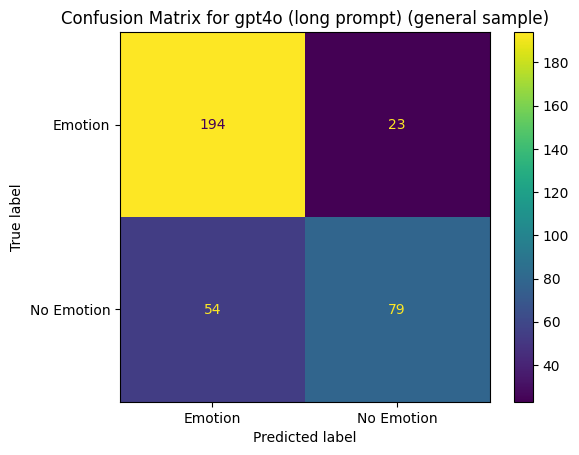

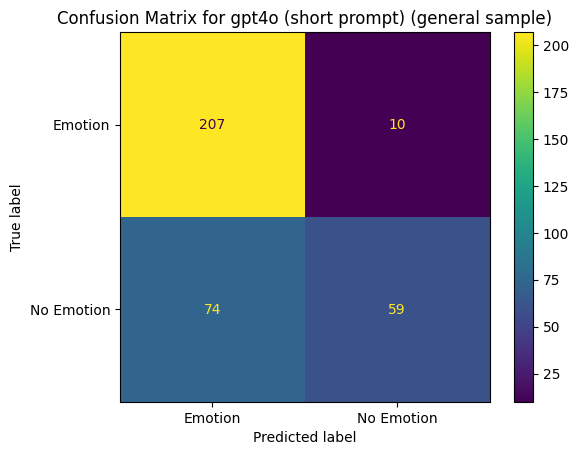

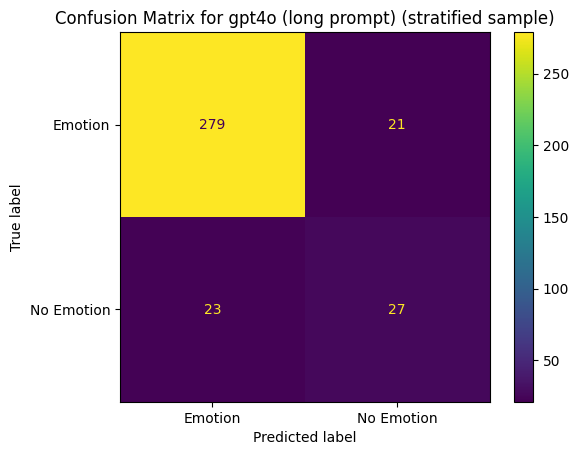

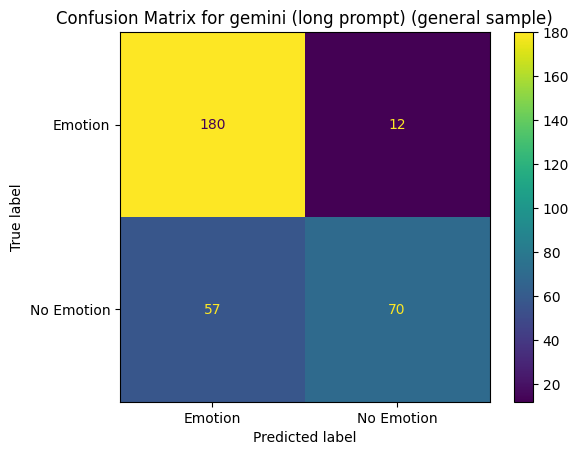

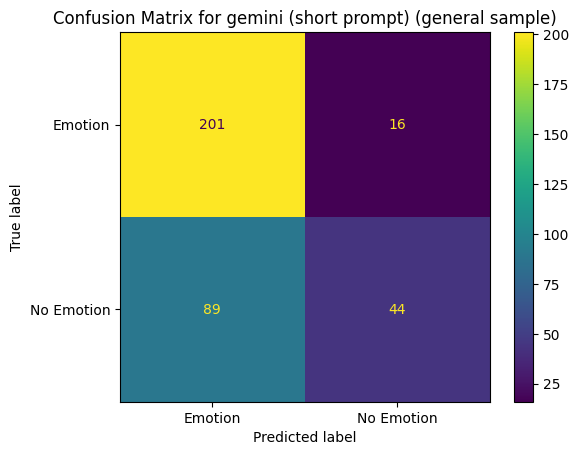

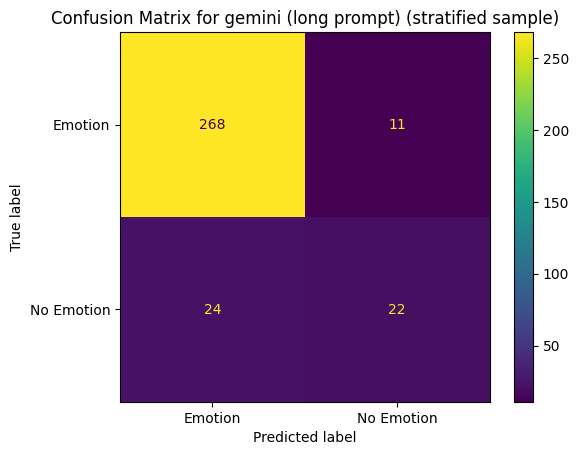

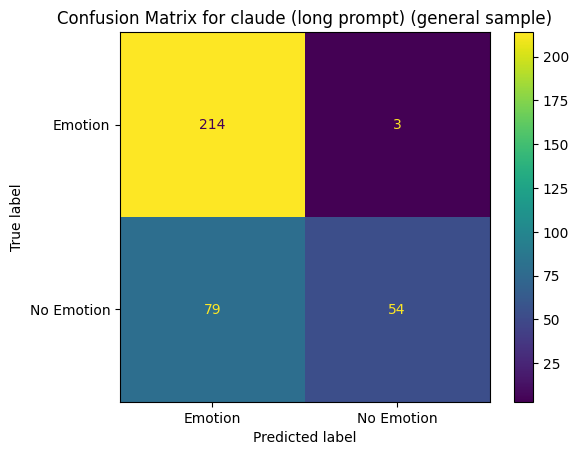

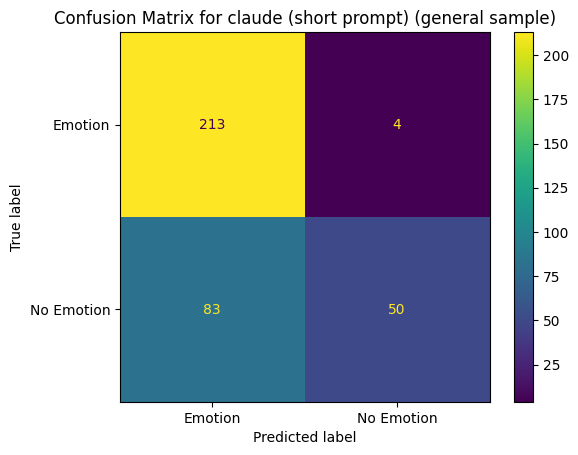

In [36]:
for model_name in possible_models:
    for sample_name in possible_samples:
        for prompt_name in possible_prompts:
            if sample_name == 'general':
                df_analysis = df_gen
            if sample_name == 'stratified':
                df_analysis = df_strat
        
            if f'{model_name}_{prompt_name}_annotation' not in df_analysis.columns:
                continue
        
            df_analysis = df_analysis[df_analysis[f'{model_name}_{prompt_name}_annotation'].notna()]
            df_analysis = df_analysis[df_analysis[f'{model_name}_{prompt_name}_annotation'] != 'no_annotation_found']
        
            y_true = df_analysis['None']
            y_pred = df_analysis[f'{model_name}_{prompt_name}_None']
            cm = confusion_matrix(y_true, y_pred)
            
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Emotion', 'No Emotion'])
            disp.plot()
            plt.title(f'Confusion Matrix for {model_name} ({prompt_name} prompt) ({sample_name} sample)')
            plt.show()        

In [37]:
# df_test = df that combines gen + strat and that includes only stanzas with annotations from all models
df_test = pd.concat([
    df_gen,
    df_strat
]).copy()

df_test = (
    df_test
    .query("gpt4o_short_annotation.notna() and gpt4o_short_annotation != 'no_annotation_found'")
    .query("gemini_short_annotation.notna() and gemini_short_annotation != 'no_annotation_found'")
    .query("claude_short_annotation.notna() and claude_short_annotation != 'no_annotation_found'")
    .query("gpt4o_long_annotation.notna() and gpt4o_long_annotation != 'no_annotation_found'")
    .query("gemini_long_annotation.notna() and gemini_long_annotation != 'no_annotation_found'")
    .query("claude_long_annotation.notna() and claude_long_annotation != 'no_annotation_found'")
).copy()
df_test['We_None'] = df_test['None']

df_test.shape[0]

319

In [38]:
df_only_models_see_emotion = (
    df_test
    .query("We_None == 1")
    .query("gpt4o_short_None == 0")
    .query("gemini_short_None == 0")
    .query("claude_short_None == 0")
    .query("gpt4o_long_None == 0")
    .query("gemini_long_None == 0")
    .query("claude_long_None == 0")
)

df_only_models_see_emotion.shape[0]

39

In [39]:
df_only_we_see_emotion = (
    df_test
    .query("We_None == 0")
    .query("gpt4o_short_None == 1")
    .query("gemini_short_None == 1")
    .query("claude_short_None == 1")
    .query("gpt4o_long_None == 1")
    .query("gemini_long_None == 1")
    .query("claude_long_None == 1")
)

df_only_we_see_emotion.shape[0]

2

In [40]:
for item in df_only_models_see_emotion.head(5).iloc:
    print(item.Text)
    print("\n")
    print(f"gpt4o  {item.gpt4o_long_annotation}")
    print(f"gpt4o  {item.gpt4o_long_reasoning}")
    print(f"gemini {item.gemini_long_annotation}")
    print(f"gemini {item.gemini_long_reasoning}")
    print(f"claude {item.claude_long_annotation}")
    print(f"claude {item.claude_long_reasoning}")
    print("\n")
    print("\n")

Und süße Früchte werden aus den herben
Und fallen nachts wie tote Vögel nieder
Und liegen wenig Tage und verderben.


gpt4o  ANNOTATION: SADNESS
gpt4o  REASONING: The stanza contains clear emotion markers indicating SADNESS, especially the metaphor "fallen nachts wie tote Vögel nieder" (fall at night like dead birds) and the situation of the fruits "verderben" (rotting). These markers suggest themes of decay and loss, which are associated with SADNESS.
gemini ANNOTATION: SADNESS
gemini REASONING: The stanza contains several clear emotion markers indicating SADNESS, such as the image of death ("fallen nachts wie tote Vögel nieder") and the word "verderben". 
claude ANNOTATION: SADNESS
claude REASONING: The stanza contains clear emotion markers indicating SADNESS. The metaphor of sweet fruits falling "like dead birds" and then lying for a few days before decaying evokes a strong sense of melancholy and the transient nature of life. The image of death (tote Vögel) and decay (verderben) ar

In [41]:
for item in df_only_we_see_emotion.head(5).iloc:
    print(item.Text)
    print("\n")
    print(item[emotions])
    print(f"gpt4o  {item.gpt4o_long_annotation}")
    print(f"gpt4o  {item.gpt4o_long_reasoning}")
    print(f"gemini {item.gemini_long_annotation}")
    print(f"gemini {item.gemini_long_reasoning}")
    print(f"claude {item.claude_long_annotation}")
    print(f"claude {item.claude_long_reasoning}")
    print("\n")
    print("\n")

Jugendliebe
Hopfen, Hans Ritter von [alt. Hopfen, Hans]


Agitation    0.0
Love         1.0
Joy          0.0
Sadness      0.0
Anger        0.0
Fear         0.0
None           0
Name: 3367, dtype: object
gpt4o  ANNOTATION: NONE
gpt4o  REASONING: The stanza contains no clear emotion markers according to the provided guidelines. Without additional context or specific emotional language, it does not clearly represent any of the six emotions listed.
gemini ANNOTATION: NONE
gemini REASONING: The stanza contains no clear emotion markers. 
claude ANNOTATION: NONE
claude REASONING: The given text only contains the title of the poem "Jugendliebe" and the author's name "Hopfen, Hans Ritter von [alt. Hopfen, Hans]". There are no actual stanza or verses provided, and therefore no clear emotion markers present. Without any content to analyze, we cannot determine any specific emotions represented.




Nachglück
Schöpff, Wilhelm [Pseud. Neun, Wilfried von der]


Agitation    0.0
Love         0.0
Joy  

### 40 Einzelemotionen

In [42]:
emotion_groups_dic = {
    'Agitation' : ['Emotionalität', 'Spannung', 'Überraschung/Aufregung', 'Aufregung'],
    'Joy' : ['Freude', 'Glück', 'Hoffnung', 'Geborgenheit', 'Begeisterung', 'Stolz', 'Trost', 'Ausgeglichenheit'],
    'Fear' : ['Angst', 'Erschrecken'],
    'Sadness' : ['Trauer', 'Unbehagen', 'Enttäuschung', 'Ohnmacht', 'Reue', 'Wehmut', 'Verzweiflung', 'Mitleid', 'Scham', 'Einsamkeit', 'Unsicherheit', 'Ungeduld', 'Leid'],
    'Love' : ['Liebe', 'Bewunderung', 'Dankbarkeit', 'Sehnsucht', 'Lust (nicht sexuell)', 'Zuneigung', 'Lust (sexuell)'],
    'Anger' : ['Wut', 'Neid', 'Abneigung', 'Verachtung', 'Ekel', 'Hass']
}

In [43]:
# df_test = df that combines gen + strat
df_test = pd.concat([
    df_gen,
    df_strat
]).copy()

df_test.shape[0]

700

In [44]:
for emotion_group_name in emotion_groups_dic.keys():
    emotion_sums = df_test[emotion_groups_dic[emotion_group_name]].sum()
    emotion_sums_df = pd.DataFrame(emotion_sums, columns=['count'])
    emotion_sums_df['share'] = emotion_sums_df['count']/emotion_sums_df['count'].sum()
    emotion_sums_df = emotion_sums_df.sort_values(by='share', ascending=False)
    
    print(emotion_group_name)
    print(emotion_sums_df)
    print("\n")

Agitation
                        count     share
Emotionalität            72.0  0.827586
Überraschung/Aufregung    8.0  0.091954
Aufregung                 6.0  0.068966
Spannung                  1.0  0.011494


Joy
                  count     share
Freude             96.0  0.360902
Glück              64.0  0.240602
Hoffnung           28.0  0.105263
Trost              28.0  0.105263
Begeisterung       24.0  0.090226
Ausgeglichenheit   11.0  0.041353
Stolz               9.0  0.033835
Geborgenheit        6.0  0.022556


Fear
             count     share
Angst         53.0  0.670886
Erschrecken   26.0  0.329114


Sadness
              count     share
Leid          107.0  0.414729
Trauer         63.0  0.244186
Unbehagen      19.0  0.073643
Wehmut         15.0  0.058140
Verzweiflung   15.0  0.058140
Mitleid        14.0  0.054264
Einsamkeit     11.0  0.042636
Scham           9.0  0.034884
Reue            2.0  0.007752
Ohnmacht        1.0  0.003876
Enttäuschung    1.0  0.003876
Ungeduld      

# Binary Classification

In [45]:
log_output = open("../resources/logging_5_exp_2024_Jul_23_16_54.txt",'r').read()
log_output_split = log_output.split("emotion: ")

In [46]:
log_output_agitation = [x for x in log_output_split if 'AGITATION' in x][0]
log_output_anger = [x for x in log_output_split if 'ANGER' in x][0]
log_output_fear = [x for x in log_output_split if 'FEAR' in x][0]
log_output_sadness = [x for x in log_output_split if 'SADNESS' in x][0]
log_output_joy = [x for x in log_output_split if 'JOY' in x][0]
log_output_love = [x for x in log_output_split if 'LOVE' in x][0]

log_outputs_emotions = [
    log_output_agitation,
    log_output_anger,
    log_output_fear,
    log_output_sadness,
    log_output_joy,
    log_output_love,
]

In [47]:
data_agitation = pd.read_csv("../resources/bc_Agitation.csv", sep="\t", index_col = [0])
data_anger = pd.read_csv("../resources/bc_Anger.csv", sep="\t", index_col = [0])
data_fear = pd.read_csv("../resources/bc_Fear.csv", sep="\t", index_col = [0])
data_sadness = pd.read_csv("../resources/bc_Sadness.csv", sep="\t", index_col = [0])
data_joy = pd.read_csv("../resources/bc_Joy.csv", sep="\t", index_col = [0])
data_love = pd.read_csv("../resources/bc_Love.csv", sep="\t", index_col = [0])

data_emotions = [
    data_agitation,
    data_anger,
    data_fear,
    data_sadness,
    data_joy,
    data_love,
]

In [48]:
emotion_labels = [
    'Agitation',
    'Anger',
    'Fear',
    'Sadness',
    'Joy',
    'Love',
]

In [49]:
for log_output_emotion, data_emotion, emotion_label in zip(log_outputs_emotions, data_emotions, emotion_labels):
    for response in log_output_emotion.split("\n\n"):
        index = re.findall("\\d+", response)
    
        if len(index) != 1:
            print(f"Error {emotion_label}: {response}")
            continue
    
        index = int(index[0])
        data_emotion.at[index, 'Model_response'] = response
    
        if emotion_label.upper() in response:
            data_emotion.at[index, f'Model_{emotion_label}'] = 1
        else:
            data_emotion.at[index, f'Model_{emotion_label}'] = 0

Error Agitation: AGITATION
Error Agitation: 
Error Anger: ANGER
Error Anger: 
Error Fear: FEAR
Error Fear: 
Error Sadness: SADNESS
Error Sadness: 
Error Joy: JOY
Error Joy: 
Error Love: LOVE
Error Love: 


In [50]:
data_anger.head()

,DocName,Text,Agitation,Anger,Fear,Joy,Love,Sadness,Context,ID,label,Model_response,Model_Anger
147,"Der Wind Sallet, Friedrich von","Der Wind\nSallet, Friedrich von",0.0,0.0,0.0,0.0,0.0,0.0,"Der Wind\nSallet, Friedrich von",l00200128,NONE,147: OTHER,0.0
1660,"Aus der Heimath Schack, Adolf Friedrich von","Hier ist es, wo ich als Kind gestreift\nUnd di...",0.0,0.0,0.0,0.0,0.0,1.0,"Aus der Heimath\nSchack, Adolf Friedrich von H...",l00200152,SADNESS,1660: OTHER,0.0
1260,"Einziger Ausweg Wegener, Rhingulf Eduard [alt....","Ob alle Welt mir's auch verarge,\nDer Frühling...",0.0,1.0,0.0,0.0,0.0,0.0,"Einziger Ausweg\nWegener, Rhingulf Eduard [alt...",l0080606,ANGER,1260: {'ANGER'},1.0
4184,"Keim und Kind Ebert, Karl Egon von [alt. Ebert...","Doch wenn ein holdes Kind ich sehe,\nGewiegt v...",1.0,0.0,1.0,1.0,1.0,1.0,"Keim und Kind\nEbert, Karl Egon von [alt. Eber...",l0080118,AGITATION#FEAR#JOY#LOVE#SADNESS,4184: OTHER,0.0
6799,SO SCHNEIT AUF MICH DIE TOTE ZEIT ALBERT EHREN...,So schneit auf mich die tote Zeit.\nDanklos tr...,0.0,1.0,0.0,0.0,1.0,1.0,SO SCHNEIT AUF MICH DIE TOTE ZEIT Hofft nichts...,l00300025,ANGER#LOVE#SADNESS,6799: OTHER,0.0


In [51]:
eval_results_bin = pd.DataFrame()

for log_output_emotion, data_emotion, emotion_label in zip(log_outputs_emotions, data_emotions, emotion_labels):
    eval_results_bin.at[emotion_label, 'n_samples'] = data_emotion.shape[0]
    eval_results_bin.at[emotion_label, 'annotation_positive'] = data_emotion[emotion_label].sum()
    eval_results_bin.at[emotion_label, 'prediction_positive'] = data_emotion['Model_'+emotion_label].sum()
    eval_results_bin.at[emotion_label, 'F1'] = f1_score(data_emotion[emotion_label], data_emotion['Model_'+emotion_label])
    eval_results_bin.at[emotion_label, 'Precision'] = precision_score(data_emotion[emotion_label], data_emotion['Model_'+emotion_label])
    eval_results_bin.at[emotion_label, 'Recall'] = recall_score(data_emotion[emotion_label], data_emotion['Model_'+emotion_label])
    eval_results_bin.at[emotion_label, 'Accuracy'] = accuracy_score(data_emotion[emotion_label], data_emotion['Model_'+emotion_label])

In [52]:
eval_results_bin

,n_samples,annotation_positive,prediction_positive,F1,Precision,Recall,Accuracy
Agitation,120.0,60.0,55.0,0.504348,0.527273,0.483333,0.525000
Anger,120.0,60.0,26.0,0.558140,0.923077,0.400000,0.683333
Fear,120.0,60.0,50.0,0.745455,0.820000,0.683333,0.766667
Sadness,120.0,60.0,61.0,0.760331,0.754098,0.766667,0.758333
Joy,120.0,60.0,31.0,0.461538,0.677419,0.350000,0.591667
Love,120.0,60.0,43.0,0.660194,0.790698,0.566667,0.708333
